In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./')
from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

In [2]:
csi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"
rssi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/rssi_for_4AP.csv"

In [3]:
# Load data CSI
reference_points = {}
spacing = 0.6  # 每隔 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(csi_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

data, rp_labels, coord_labels = load_data(reference_points)

In [4]:
csi = data
csi["Label"] = rp_labels

In [5]:
df_final = pd.read_csv(rssi_path)

In [9]:
import pandas as pd

# === 假設以下兩個 DataFrame 已經就緒 ===
# df_rssi: 包含 ["Label", ...] + RSSI 欄位
# df_csi:  包含 ["Label", ...] + CSI 欄位

# 取得兩邊都出現的所有 Label
common_labels = sorted(set(df_final["Label"].unique()) & set(csi["Label"].unique()))

merged_list = []

for lb in common_labels:
    # 1. 取出該 Label 的子集
    sub_rssi = df_final[df_final["Label"] == lb].reset_index(drop=True)
    sub_csi  = csi[csi["Label"] == lb].reset_index(drop=True)
    
    # 2. 檢查兩者長度是否一致
    len_rssi = len(sub_rssi)
    len_csi  = len(sub_csi)
    
    if len_rssi != len_csi:
        print(f"警告：Label={lb} 在 df_rssi 有 {len_rssi} 筆, df_csi 有 {len_csi} 筆，長度不同。")
        # 你可以選擇：略過、或僅取最短長度、或補齊…
        # 這邊示範「取最小長度」來對齊
        min_len = min(len_rssi, len_csi)
        sub_rssi = sub_rssi.iloc[:min_len].reset_index(drop=True)
        sub_csi  = sub_csi.iloc[:min_len].reset_index(drop=True)
    
    # 3. 逐列「貼合」兩個子 DataFrame (axis=1 即左右合併)
    #    如果不想留重複的 Label 欄位，可以先丟掉 sub_csi 的 Label 欄位
    sub_csi_dropped = sub_csi.drop(columns=["Label"])
    
    # 合併
    sub_merged = pd.concat([sub_rssi, sub_csi_dropped], axis=1)
    
    # 4. 把合併後的子 DataFrame 放進清單
    merged_list.append(sub_merged)

# 5. 最後把所有 Label 的結果上下堆起來
df_merged_all = pd.concat(merged_list, ignore_index=True)

# 檢查
print(df_merged_all.shape)
df_merged_all




 

(24500, 103)


,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi,0,1,2,3,4,...,88,89,90,91,92,93,94,95,96,97
0,1,-62.0,-72.0,-65.0,-54.0,919.592301,929.595611,877.760787,898.203763,851.400023,...,-1.387518,-1.581549,-1.708760,-2.080869,-2.287379,-2.467120,-2.666997,-2.982241,-50.0,136.0
1,1,-61.0,-73.0,-66.0,-56.0,698.204841,732.963846,684.079674,694.257877,651.079872,...,-2.677159,-2.877730,-3.051501,2.738820,2.503722,2.256683,2.035376,1.737005,-49.0,148.0
2,1,-62.0,-72.0,-66.0,-55.0,745.268408,768.188128,706.606680,713.252410,681.482208,...,0.176051,-0.063704,-0.251636,-0.776139,-1.023850,-1.275624,-1.535994,-1.899522,-50.0,224.0
3,1,-61.0,-73.0,-66.0,-55.0,830.278267,829.860832,804.005597,796.492310,786.787138,...,-1.031820,-1.194379,-1.338067,-1.666445,-1.878363,-2.100073,-2.369892,-2.666982,-51.0,136.0
4,1,-54.0,-72.0,-67.0,-55.0,906.099884,903.507056,910.843565,896.688352,892.235955,...,-0.445534,-0.593750,-0.783166,-1.090942,-1.286103,-1.497279,-1.784787,-2.076610,-50.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24495,49,-54.0,-64.0,-56.0,-58.0,397.615392,416.889674,395.588170,413.019370,382.733589,...,2.183710,2.005190,1.826107,1.364322,1.150287,0.872978,0.573063,0.255977,-56.0,148.0
24496,49,-55.0,-65.0,-56.0,-57.0,643.708785,646.260010,627.624888,621.498994,605.152873,...,-0.494557,-0.782703,-1.053078,-1.631902,-1.969954,-2.328378,-2.758960,3.087458,-59.0,136.0
24497,49,-53.0,-63.0,-53.0,-56.0,762.685387,745.553486,706.884007,695.708272,698.951357,...,0.621717,0.498336,0.356470,-0.131807,-0.426306,-0.748795,-1.031706,-1.339351,-58.0,136.0
24498,49,-53.0,-64.0,-55.0,-59.0,401.220638,416.688133,388.561449,390.436935,370.411933,...,-1.801749,-2.120022,-2.410138,3.138034,2.751942,2.306627,1.868269,1.432071,-56.0,148.0


In [10]:
rssi_columns = ['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']
df_merged_all[rssi_columns] = df_merged_all[rssi_columns].fillna(0)

In [11]:
rp_labels = df_merged_all['Label']
csi = df_merged_all.drop(columns=['Label', 'AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi'])
amp = csi.iloc[:,:48]
phase = csi.iloc[:,48:-2]
rssi = df_merged_all[['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']]

In [12]:
print("csi shape:", rssi.shape)
print("amp shape:", amp.shape)

csi shape: (24500, 4)
amp shape: (24500, 48)


In [13]:
type(amp)
amp1 = amp.to_numpy()

In [48]:
from sklearn.model_selection import train_test_split

# 指定不訓練的 label（測試點）
#第一組 test_labels = [4,8,43,47,24,29]
#第二組 
test_labels = [3, 6, 9, 48, 45, 42, 23, 29, 26]
# 1️⃣ 篩出 test 與 train+val index
test_idx = rp_labels[rp_labels.isin(test_labels)].index
trainval_idx = rp_labels[~rp_labels.isin(test_labels)].index
trainval_labels = rp_labels.loc[trainval_idx]

# 2️⃣ 從 trainval 中 stratified 切出 validation（例如 15% 作 val）
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=0.15,
    stratify=trainval_labels,
    random_state=42
)

# 3️⃣ 根據 index 切資料
amp_train = amp.loc[train_idx]
rssi_train = rssi.loc[train_idx]
y_train = rp_labels.loc[train_idx]

amp_val = amp.loc[val_idx]
rssi_val = rssi.loc[val_idx]
y_val = rp_labels.loc[val_idx]

amp_test = amp.loc[test_idx]
rssi_test = rssi.loc[test_idx]
y_test = rp_labels.loc[test_idx]



In [49]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# 先定義所有可能的 label（1~49）
all_labels = np.array(sorted(rp_labels.unique())).reshape(-1, 1)

# 初始化 OneHotEncoder，指定 categories 為全部 49 類
encoder = OneHotEncoder(categories=[all_labels.ravel()], sparse_output=False, handle_unknown='ignore')

# 用 full label space fit
encoder.fit(all_labels)

# 分別轉換
y_train_oh = encoder.transform(np.array(y_train).reshape(-1, 1))
y_val_oh   = encoder.transform(np.array(y_val).reshape(-1, 1))
y_test_oh  = encoder.transform(np.array(y_test).reshape(-1, 1))


In [38]:
print("y_train_oh shape:", y_train_oh.shape)
print("y_val_oh shape:", y_val_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)

y_train_oh shape: (18275, 49)
y_val_oh shape: (3225, 49)
y_test_oh shape: (3000, 49)


In [50]:
# 創建 Dataset 和 DataLoader

batch_size = 32

train_dataset = CSIRSSIDataset(np.array(amp_train), np.array(rssi_train), y_train_oh, augment=True, csi_noise_std=0.00, rssi_mask_prob=0.05)
val_dataset = CSIRSSIDataset(np.array(amp_val),np.array(rssi_val), y_val_oh)
test_dataset = CSIRSSIDataset(np.array(amp_test), np.array(rssi_test), y_test_oh)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os

# 假設模型已經定義好
class CSIRSSI_Classifier_BN(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSI_Classifier_BN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten_dim = 128 * 12
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc_rssi1 = nn.Linear(rssi_dim, 128)
        self.bn_rssi1 = nn.BatchNorm1d(128)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(128, 32)
        self.bn_rssi2 = nn.BatchNorm1d(32)
        self.dropout_rssi2 = nn.Dropout(0.5)

        self.fc_fusion = nn.Linear(64 + 32, 64)
        self.dropout_fusion = nn.Dropout(0.3)
        self.fc_class = nn.Linear(64, num_classes)

    def forward(self, csi_input, rssi_input):
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)

        rssi_feat = F.relu(self.bn_rssi1(self.fc_rssi1(rssi_input)))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.bn_rssi2(self.fc_rssi2(rssi_feat)))
        rssi_feat = self.dropout_rssi2(rssi_feat)

        fusion = torch.cat([csi_feat, rssi_feat], dim=1)
        fusion = F.relu(self.fc_fusion(fusion))
        fusion = self.dropout_fusion(fusion)

        class_out = self.fc_class(fusion)
        return class_out




In [52]:
import torch.nn as nn
import torch.optim as optim

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os

num_runs = 1
epochs = 300
patience = 20

# ===== 你的模型 CSIRSSI_Classifier_BN 定義在這裡（略） =====

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_loader, val_loader, test_loader
# criterion = nn.CrossEntropyLoss()
# COORDINATES = {1: (x1, y1), ..., 49: (xn, yn)}
# compute_mean_distance_error(y_true, y_pred, COORDINATES)


def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)

test_accs = []
test_mdes = []
all_run_errors = []

for run in range(1, num_runs + 1):
    print(f"\n=== Run {run}/{num_runs} ===")

    model = CSIRSSI_Classifier_BN(num_classes=49).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    criterion_cls = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        for csi_inputs, rssi_inputs, labels in train_loader:
            csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
            target_class = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            class_out = model(csi_inputs, rssi_inputs)
            loss = criterion_cls(class_out, target_class)
            loss.backward()
            optimizer.step()

        # 驗證
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for csi_inputs, rssi_inputs, labels in val_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                class_out = model(csi_inputs, rssi_inputs)
                val_loss += criterion_cls(class_out, target_class).item() * csi_inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    # 測試
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for csi_inputs, rssi_inputs, labels in test_loader:
            csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
            target_class = torch.argmax(labels, dim=1)
            class_out = model(csi_inputs, rssi_inputs)
            pred = torch.argmax(class_out, dim=1)
            all_pred.extend(pred.cpu().numpy())
            all_true.extend(target_class.cpu().numpy())

    y_true = np.array(all_true) + 1
    y_pred = np.array(all_pred) + 1
    acc = 100 * np.mean(y_true == y_pred)
    mde, errors = compute_mean_distance_error(y_true, y_pred, COORDINATES)

    test_accs.append(acc)
    test_mdes.append(mde)
    all_run_errors.append(errors)
    print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

# 儲存 summary 結果
os.makedirs("repeat_for_zero_shot/00", exist_ok=True)
df = pd.DataFrame({
    "run": list(range(1, num_runs+1)),
    "accuracy": test_accs,
    "mde": test_mdes
})
df.to_csv("repeat_for_zero_shot/00/csirssi_cls_results00_errorK2.csv", index=False)

# 儲存所有 error（長條格式）
error_records = []
for run_idx, errors in enumerate(all_run_errors):
    for sample_idx, e in enumerate(errors):
        error_records.append({
            "run": run_idx + 1,
            "sample_idx": sample_idx + 1,
            "error": e
        })
df_errors = pd.DataFrame(error_records)
df_errors.to_csv("repeat_for_zero_shot/00/csirssi_cls_all_errors00K2.csv", index=False)




=== Run 1/1 ===
✅ Run 1: Acc = 0.00%, MDE = 3.0372


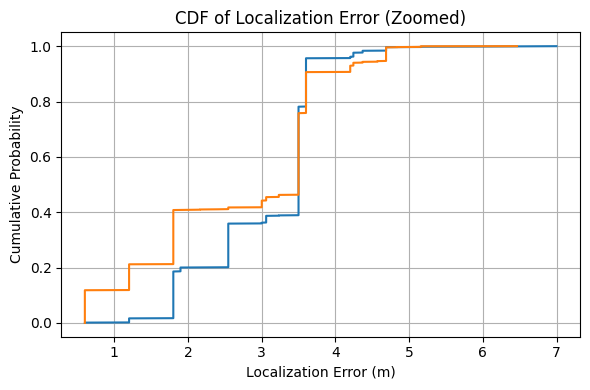

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取 error 檔
df = pd.read_csv("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/repeat_for_zero_shot/00/csirssi_cls_all_errors00K.csv")
df2 = pd.read_csv("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/repeat_for_zero_shot/0.9/all_errors.csv")
errors = df["error"].values
errors2 = df2["error"].values
# 1. 全部 error 的 CDF
sorted_errors = np.sort(errors)
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
sorted_errors2 = np.sort(errors2)
cdf2 = np.arange(1, len(sorted_errors2) + 1) / len(sorted_errors2)
# 2. Zoom-in：只看 Y=0.99~1.0 區間
plt.figure(figsize=(6,4))
plt.plot(sorted_errors, cdf, label="CDF (Zoom 0.99~1.0)")
plt.plot(sorted_errors2, cdf2, label="CDF (Zoom 0.99~1.0)")
plt.xlabel("Localization Error (m)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Localization Error (Zoomed)")
#plt.ylim(0.995, 1.00)
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary  # torchinfo 可用來顯示多輸入模型摘要
import matplotlib.pyplot as plt

# -----------------------
# 模型定義：CSIRSSI_DualHead
# -----------------------
class CSIRSSI_DualHead_BN(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSI_DualHead_BN, self).__init__()
        # ---- CSI 分支 (CNN) ---
        # 假設輸入 CSI shape 為 (batch, 1, 48)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # 輸入長度 48 → 經過兩次 pooling → 48/2=24，再 24/2=12
        self.flatten_dim = 128 * 12
        
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        # 此時 CSI 分支輸出 64 維特徵
        
        # ---- RSSI 分支 (MLP) ----
        self.fc_rssi1 = nn.Linear(rssi_dim, 128)
        self.bn_rssi1 = nn.BatchNorm1d(128)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(128, 32)
        self.bn_rssi2 = nn.BatchNorm1d(32)
        self.dropout_rssi2 = nn.Dropout(0.5)
        # RSSI 分支輸出 32 維特徵
        
        # ---- 融合層 ----
        # 將 CSI (64-d) 與 RSSI (32-d) 連接 → 96-d
        self.fc_fusion = nn.Linear(64+32, 64)
        self.dropout_fusion = nn.Dropout(0.3)
        
        # ---- 雙輸出頭 ----
        # 分類頭：輸出 num_classes 個類別的 logits
        self.fc_class = nn.Linear(64, num_classes)
        # 回歸頭：輸出 2 個數值 (X, Y)
        self.fc_reg = nn.Linear(64, 2)
    
    def forward(self, csi_input, rssi_input):
        # CSI 分支
        # 如果輸入為 (batch, 48)，則擴展成 (batch, 1, 48)
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # flatten → (batch, flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)
        
        # RSSI 分支
        rssi_feat = F.relu(self.bn_rssi1(self.fc_rssi1(rssi_input)))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.bn_rssi2(self.fc_rssi2(rssi_feat)))
        rssi_feat = self.dropout_rssi2(rssi_feat)
        
        # 融合特徵
        fusion = torch.cat([csi_feat, rssi_feat], dim=1)  # (batch, 96)
        fusion = F.relu(self.fc_fusion(fusion))
        fusion = self.dropout_fusion(fusion)
        
        # 雙輸出頭
        class_out = self.fc_class(fusion)  # 分類輸出 (batch, num_classes)
        reg_out = self.fc_reg(fusion)       # 回歸輸出 (batch, 2)
        
        return class_out, reg_out

# -----------------------
# 模型初始化與摘要
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSIRSSI_DualHead_BN(num_classes=49, rssi_dim=4).to(device)

print("模型摘要:")
summary(model, input_data=(torch.randn(1, 1, 48).to(device), torch.randn(1, 4).to(device)))

模型摘要:


Layer (type:depth-idx)                   Output Shape              Param #
CSIRSSI_DualHead_BN                      [1, 49]                   --
├─Conv1d: 1-1                            [1, 64, 48]               256
├─BatchNorm1d: 1-2                       [1, 64, 48]               128
├─MaxPool1d: 1-3                         [1, 64, 24]               --
├─Conv1d: 1-4                            [1, 128, 24]              24,704
├─BatchNorm1d: 1-5                       [1, 128, 24]              256
├─MaxPool1d: 1-6                         [1, 128, 12]              --
├─Linear: 1-7                            [1, 128]                  196,736
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─Dropout: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 128]                  640
├─BatchNorm1d: 1-12                      [1, 128]                  25

In [55]:
alphas = [round(a, 1) for a in np.arange(0.1, 1.01, 0.1)]
num_runs = 1
epochs = 300
patience = 20
criterion = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
for alpha in alphas:
    test_accs = []
    test_mdes = []
    all_run_errors = []

    print(f"\n[Alpha = {alpha:.1f}] 開始 {num_runs} 次訓練")
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs} - Alpha = {alpha:.1f}")
        model = CSIRSSI_DualHead_BN(num_classes=49, rssi_dim=4).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
        best_val_loss = float('inf')
        counter = 0

        for epoch in range(epochs):
            model.train()
            for csi_inputs, rssi_inputs, labels in train_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                optimizer.zero_grad()
                class_out, reg_out = model(csi_inputs, rssi_inputs)
                loss_cls = criterion(class_out, target_class)
                loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
                loss = loss_cls + alpha * loss_reg
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for csi_inputs, rssi_inputs, labels in val_loader:
                    csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                    target_class = torch.argmax(labels, dim=1)
                    class_out, reg_out = model(csi_inputs, rssi_inputs)
                    loss_cls = criterion(class_out, target_class)
                    loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
                    val_loss += (loss_cls + alpha * loss_reg).item() * csi_inputs.size(0)

            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

        # Testing
        model.eval()
        all_true, all_pred = [], []
        with torch.no_grad():
            for csi_inputs, rssi_inputs, labels in test_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                class_out, _ = model(csi_inputs, rssi_inputs)
                pred = torch.argmax(class_out, dim=1)
                all_pred.extend(pred.cpu().numpy())
                all_true.extend(target_class.cpu().numpy())

        y_true = np.array(all_true) + 1
        y_pred = np.array(all_pred) + 1
        acc = 100 * np.mean(y_true == y_pred)
        mde, errors = compute_mean_distance_error(y_true, y_pred, COORDINATES)

        test_accs.append(acc)
        test_mdes.append(mde)
        all_run_errors.append(errors)
        print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

    # 儲存結果
    folder_name = f"repeat_for_zero_shot/{alpha:.1f}"
    os.makedirs(folder_name, exist_ok=True)

    df_runs = pd.DataFrame({
        'run': list(range(1, num_runs + 1)),
        'accuracy': test_accs,
        'mde': test_mdes
    })
    df_runs.to_csv(f"{folder_name}/summaryK2.csv", index=False)

    error_records = []
    for run_idx, errors in enumerate(all_run_errors):
        for sample_idx, e in enumerate(errors):
            error_records.append({
                "run": run_idx + 1,
                "sample_idx": sample_idx + 1,
                "error": e
            })
    df_errors = pd.DataFrame(error_records)
    df_errors.to_csv(f"{folder_name}/all_errorsK2.csv", index=False)
    print("📁 Results & all errors saved to", folder_name)



[Alpha = 0.1] 開始 1 次訓練
Run 1/1 - Alpha = 0.1
✅ Run 1: Acc = 0.00%, MDE = 3.1252
📁 Results & all errors saved to repeat_for_zero_shot/0.1

[Alpha = 0.2] 開始 1 次訓練
Run 1/1 - Alpha = 0.2
✅ Run 1: Acc = 0.00%, MDE = 3.5973
📁 Results & all errors saved to repeat_for_zero_shot/0.2

[Alpha = 0.3] 開始 1 次訓練
Run 1/1 - Alpha = 0.3
✅ Run 1: Acc = 0.00%, MDE = 3.6446
📁 Results & all errors saved to repeat_for_zero_shot/0.3

[Alpha = 0.4] 開始 1 次訓練
Run 1/1 - Alpha = 0.4


KeyboardInterrupt: 